# Assignment 1

This Jupyter Notebook document is our implementation of Assignment 1. 


In [2]:
# !pip install pandas 
# !pip install numpy
# !pip install matplotlib
# !pip install tqdm
# !pip install seaborn
# !pip install tensorflow
# !pip install keras
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\alepa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Importing Libraries

    

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os
from tqdm import tqdm
import copy
import seaborn as sns
import sklearn

# Task 1: Data Loading and Splitting
* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

[Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

In [4]:
# Create documents dataframe
dp_docs = [file for file in os.listdir('dependency_treebank/') if file.endswith('.dp')]
dataframes = []

for file in tqdm(dp_docs):
    with open('dependency_treebank/' + file, 'r') as f:
        lines = f.readlines()
        data = [line.split('\t') for line in lines]
        df = pd.DataFrame(data, columns=['word', 'pos', 'head'])
        # drop the last column
        df = df.iloc[:, :-1]
        dataframes.append(df)

df = pd.DataFrame({'Dataframes': dataframes})
print(df.head(5))
print(df['Dataframes'][0][0:5])
print(df.shape)

100%|██████████| 199/199 [00:02<00:00, 72.07it/s]

                                          Dataframes
0              word   pos
0         Pierre   NNP
...
1              word  pos
0        Rudolph  NNP
1 ...
2           word   pos
0           A    DT
1     ...
3               word  pos
0          Yields  NNS
...
4                 word   pos
0              J.P. ...
     word  pos
0  Pierre  NNP
1  Vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS
(199, 1)


In [5]:
# Split the dataframes into train, validation and test sets
train = df['Dataframes'][0:100]
val = df['Dataframes'][100:150]
test = df['Dataframes'][150:200]

print(train.shape)
print(val.shape)
print(test.shape)

(100,)
(50,)
(49,)


In [6]:
# Text preprocessing
def to_lower_case(df, docs):
    for i in range(docs, docs + len(df)):
        df[i]['word'] = df[i]['word'].str.lower()

to_lower_case(train, 0)
to_lower_case(val, 100)
to_lower_case(test, 150)
print(train[0][0:5])

     word  pos
0  pierre  NNP
1  vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS


In [7]:
# Text preprocessing: from each doc remove newlines and empty lines
def remove_newlines(df, docs):
    for i in range(docs, docs + len(df)):
        df[i] = df[i][df[i]['word'] != '\n']
        df[i] = df[i][df[i]['word'] != '']

print(len(train[0]))
remove_newlines(train, 0)
remove_newlines(val, 100)
remove_newlines(test, 150)
print(train[0])
print(len(train[0]))
print(len(val[100]))
print(len(test[150]))

32
            word  pos
0         pierre  NNP
1         vinken  NNP
2              ,    ,
3             61   CD
4          years  NNS
5            old   JJ
6              ,    ,
7           will   MD
8           join   VB
9            the   DT
10         board   NN
11            as   IN
12             a   DT
13  nonexecutive   JJ
14      director   NN
15          nov.  NNP
16            29   CD
17             .    .
19           mr.  NNP
20        vinken  NNP
21            is  VBZ
22      chairman   NN
23            of   IN
24      elsevier  NNP
25          n.v.  NNP
26             ,    ,
27           the   DT
28         dutch  NNP
29    publishing  VBG
30         group   NN
31             .    .
31
827
220


In [8]:
# Create new dataframe that contains the single sentences
def create_sentences(df, docs):
    sentences = []
    chunks = []
    for i in range(docs, docs + len(df)):
        for element in df[i]['word']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                sentences.append(chunks)
                chunks = []
    return sentences

# Create sentences for train, val and test
train_sentences = create_sentences(train, 0)
val_sentences = create_sentences(val, 100)
test_sentences = create_sentences(test, 150)
print(len(train_sentences))
print(len(val_sentences))
print(len(test_sentences))

1959
1277
638


In [9]:
def create_tag_sentences(df, docs):
    tag_sentences = []
    chunks = []
    for i in range(docs, docs + len(df)):
        for element in df[i]['pos']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                tag_sentences.append(chunks)
                chunks = []
    return tag_sentences

# Create tag sentences for train, val and test
train_tag_sentences = create_tag_sentences(train, 0)
val_tag_sentences = create_tag_sentences(val, 100)
test_tag_sentences = create_tag_sentences(test, 150)
print(len(train_tag_sentences))
print(len(val_tag_sentences))
print(len(test_tag_sentences))


1959
1277
638


In [10]:
print(len(train_sentences[0]))
print(len(train_tag_sentences[0]))

18
18


# Task 2: Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [11]:
# Encode train sentences and tags
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

sentence_tokenizer = Tokenizer(oov_token='<UNK>')
sentence_tokenizer.fit_on_texts(train_sentences)
encoded_train_sentences = sentence_tokenizer.texts_to_sequences(train_sentences)
encoded_val_sentences = sentence_tokenizer.texts_to_sequences(val_sentences)
encoded_test_sentences = sentence_tokenizer.texts_to_sequences(test_sentences)

print(f'OOV token: {sentence_tokenizer.oov_token}')
print(f'OOV index: {sentence_tokenizer.word_index[sentence_tokenizer.oov_token]}')
print(f'Vocabulary size: {len(sentence_tokenizer.word_index)}')
print(encoded_train_sentences[0])
print(encoded_val_sentences[0])
print(encoded_test_sentences[0])

OOV token: <UNK>
OOV index: 1
Vocabulary size: 7405
[3427, 2309, 2, 1744, 65, 343, 2, 41, 1371, 3, 192, 24, 7, 1120, 270, 708, 2310, 4]
[7, 1, 1033, 839, 298, 1, 5, 7, 1112, 10, 49, 55, 15, 392, 44, 8, 186, 1888, 10, 4437, 12, 1, 2348, 19, 15, 1, 44, 8, 508, 9, 1094, 1, 8, 1669, 260, 8, 1447, 5, 1, 576, 128, 9, 144, 4]
[1, 1, 99, 2, 1349, 5229, 2, 753, 2, 17, 18, 1238, 1, 44, 140, 2, 45, 43, 560, 38, 2, 5, 30, 168, 85, 35, 34, 1, 1031, 10, 15, 1, 7, 123, 2, 45, 15, 6185, 44, 4]


In [12]:
# I print and decode sentence 0
i = 2
print(encoded_train_sentences[i])
print(sentence_tokenizer.sequences_to_texts(encoded_train_sentences[i:i+1]))

[1746, 3430, 2, 959, 65, 343, 9, 497, 166, 5, 2311, 1121, 553, 1747, 2, 25, 448, 7, 1120, 270, 5, 46, 1122, 498, 3431, 4]
['rudolph agnew , 55 years old and former chairman of consolidated gold fields plc , was named a nonexecutive director of this british industrial conglomerate .']


In [13]:
tag_tokenizer = Tokenizer(oov_token='<UNK>')
tag_tokenizer.fit_on_texts(train_tag_sentences)
encoded_train_tags = tag_tokenizer.texts_to_sequences(train_tag_sentences)
encoded_val_tags = tag_tokenizer.texts_to_sequences(val_tag_sentences)
encoded_test_tags = tag_tokenizer.texts_to_sequences(test_tag_sentences)

print(f'Tag vocabulary size: {len(tag_tokenizer.word_index)}')
print(encoded_train_tags[0])

Tag vocabulary size: 46
[3, 3, 8, 12, 6, 7, 8, 21, 13, 5, 2, 4, 5, 7, 2, 3, 12, 9]


250


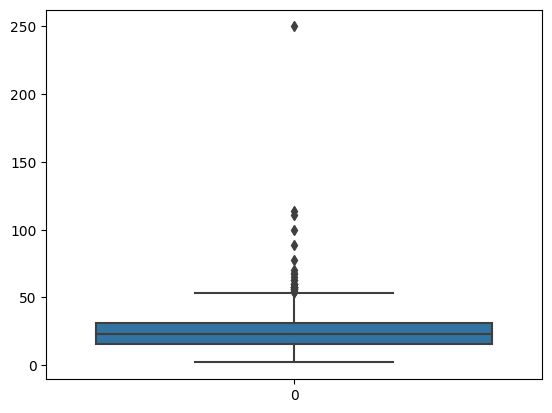

In [14]:
# check length of longest sentence 
lengths = [len(sentence) for sentence in encoded_train_sentences]
print(max(lengths))
sns.boxplot(lengths)
plt.show()

In [15]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100
train_padded = pad_sequences(encoded_train_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
train_tag_padded = pad_sequences(encoded_train_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
val_padded = pad_sequences(encoded_val_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
val_tag_padded = pad_sequences(encoded_val_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
test_padded = pad_sequences(encoded_test_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
test_tag_padded = pad_sequences(encoded_test_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')

print(train_padded[0])
print(train_tag_padded[0])
print(len(train_padded[0]))
print(len(train_tag_padded[0]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 3427 2309
    2 1744   65  343    2   41 1371    3  192   24    7 1120  270  708
 2310    4]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  3  8 12  6  7  8 21 13  5  2  4  5  7
  2  3 12  9]
100
100


In [16]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = ""
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [17]:
# Glove -> 50, 100, 200, 300
embedding_model = load_embedding_model(embedding_dimension=50)

In [18]:
def create_embedding_matrix(embedding_model, word2id, embedding_dim):
    vocab_size = len(word2id) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    OOV_embedding = np.random.rand(embedding_dim)
    count_not_in_glove = 0
    for word, i in tqdm(word2id.items()):
        try:
            embedding_matrix[i, :] = embedding_model[word]
        except KeyError:
            if word == '<UNK>':
                # give <UNK> a static embedding
                embedding_matrix[i, :] = OOV_embedding
                continue
            # If the word is not in the embedding model, it will have a random embedding vector, but check that its not already present
            embedding_vector = np.random.rand(embedding_dim)
            while embedding_vector in embedding_matrix:
                embedding_vector = np.random.rand(embedding_dim)
            embedding_matrix[i, :] = embedding_vector
            count_not_in_glove += 1
    print(f'Number of words that have no glove embedding: {count_not_in_glove}')
    return embedding_matrix

embedding_dim = 50
embedding_train_matrix = create_embedding_matrix(embedding_model, sentence_tokenizer.word_index, embedding_dim)
print(embedding_train_matrix.shape)

100%|██████████| 7405/7405 [00:00<00:00, 82251.71it/s]

Number of words that have no glove embedding: 359
(7406, 50)


In [19]:
# For tags use one-hot encoding
from keras.utils import to_categorical

Y = to_categorical(train_tag_padded)
print(Y.shape)
print(Y[0])

(1959, 100, 47)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
print(train_tag_padded.shape)
print(train_padded.shape)

(1959, 100)
(1959, 100)


In [21]:
print("Embeddings shape: {}".format(embedding_train_matrix.shape))

Embeddings shape: (7406, 50)


In [22]:
# Split the data into train, val and test sets
X_train = train_padded
Y_train = Y
X_val = val_padded
Y_val = to_categorical(val_tag_padded)
X_test = test_padded
# for test also consider the missing tags
Y_test = to_categorical(test_tag_padded, num_classes=len(tag_tokenizer.word_index)+1)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1959, 100)
(1959, 100, 47)
(1277, 100)
(1277, 100, 47)
(638, 100)
(638, 100, 47)


In [23]:
def check_OOV_terms(X):
    count_OOV = 0
    for sentence in X:
        for word in sentence:
            if word == 1:
                count_OOV += 1
    print(f'Number of OOV terms: {count_OOV}')

check_OOV_terms(X_train)
check_OOV_terms(X_val)
check_OOV_terms(X_test)

Number of OOV terms: 0
Number of OOV terms: 3746
Number of OOV terms: 1969


# Task 3: Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, TimeDistributed, Dropout
from keras.optimizers import Adam
import pickle

num_tags = Y_train.shape[2]

### Baseline





In [ ]:
# Baseline model: LSTM + FC

#HYPERPARAMETERS TUNING:
'''
def create_baseline_model(lstm_units, dropout_rate, recurrent_dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(sentence_tokenizer.word_index)+1, output_dim=embedding_dim, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=True, mask_zero=True))
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
    model.add(TimeDistributed(Dense(num_tags, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

hyperparameters = { 'lstm_units': [128, 256], 
                    'dropout_rate': [0.1, 0.2, 0.3],
                    'recurrent_dropout_rate': [0.1, 0.2, 0.3],
                    'learning_rate': [0.001, 0.01],
                    'batch_size': [32, 64, 128]
                  }
# for each hyperparameter combination, train the model for 3 epochs and save the model with the best validation accuracy
from sklearn.model_selection import ParameterGrid

# create a list of all possible combinations of hyperparameters
param_grid = ParameterGrid(hyperparameters)
print(f'Number of hyperparameter combinations: {len(param_grid)}')

# train the model for each hyperparameter combination
from sklearn.metrics import accuracy_score

best_baseline_val_accuracy = 0
best_baseline_model = None
best_baseline_hyperparameters = None

for params in tqdm(param_grid):
    model = create_baseline_model(params['lstm_units'], params['dropout_rate'], params['recurrent_dropout_rate'], params['learning_rate'])
    model.fit(X_train, Y_train, epochs=1, batch_size=params['batch_size'], verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=0)
    if val_accuracy > best_baseline_val_accuracy:
        best_baseline_val_accuracy = val_accuracy
        best_baseline_model = model
        best_baseline_hyperparameters = params

print(f'Best validation accuracy: {best_baseline_val_accuracy}')
print(f'Best hyperparameters: {best_baseline_hyperparameters}') 

# save the hyperparameters and the model
import pickle
with open('best_baseline_hyperparameters.pickle', 'wb') as f:
    pickle.dump(best_baseline_hyperparameters, f)
best_baseline_model.save('best_baseline_model.h5')
'''

In [25]:
# load the model
baseline = keras.models.load_model('best_baseline_model.h5')
best_baseline_hyperparameters = pickle.load(open('best_baseline_hyperparameters.pickle', 'rb'))
baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           370300    
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          183296    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 100, 47)           12079     
 ributed)                                                        
                                                                 
Total params: 565675 (2.16 MB)
Trainable params: 565675 (2.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model 1

In [26]:
# Model 1: LSTM + LSTM + FC

#HYPERPARAMETERS TUNING:
'''
def create_model1(lstm_units, dropout_rate, recurrent_dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(sentence_tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=True, mask_zero=True))
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
    model.add(Bidirectional(LSTM(units=int(lstm_units/2), return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
    model.add(TimeDistributed(Dense(num_tags, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

# use same hyperparameters as baseline model
best_model1_val_accuracy = 0
best_model1_model = None
best_model1_hyperparameters = None

for params in tqdm(param_grid):
    model = create_model1(params['lstm_units'], params['dropout_rate'], params['recurrent_dropout_rate'], params['learning_rate'])
    model.fit(X_train, Y_train, epochs=1, batch_size=params['batch_size'], verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=0)
    if val_accuracy > best_model1_val_accuracy:
        best_model1_val_accuracy = val_accuracy
        best_model1_model = model
        best_model1_hyperparameters = params

print(f'Best validation accuracy: {best_model1_val_accuracy}')
print(f'Best hyperparameters: {best_model1_hyperparameters}')

# save the hyperparameters and the model
with open('best_model1_hyperparameters.pickle', 'wb') as f:
    pickle.dump(best_model1_hyperparameters, f)
best_model1_model.save('best_model1_model.h5')
'''

In [27]:
# load the model
model1 = keras.models.load_model('best_model1_model.h5')
best_model1_hyperparameters = pickle.load(open('best_model1_hyperparameters.pickle', 'rb'))
model1.summary()

### Model 2

In [28]:
# Model 2: LSTM + FC + FC

#HYPERPARAMETERS TUNING:
'''
def create_model2(lstm_units, dropout_rate, recurrent_dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(sentence_tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=True, mask_zero=True))
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
    model.add(TimeDistributed(Dense(num_tags*2, activation="softmax")))
    model.add(TimeDistributed(Dense(num_tags, activation="softmax")))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

# use same hyperparameters as baseline model
best_model2_val_accuracy = 0
best_model2_model = None
best_model2_hyperparameters = None

for params in tqdm(param_grid):
    model = create_model2(params['lstm_units'], params['dropout_rate'], params['recurrent_dropout_rate'], params['learning_rate'])
    model.fit(X_train, Y_train, epochs=1, batch_size=params['batch_size'], verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=0)
    if val_accuracy > best_model2_val_accuracy:
        best_model2_val_accuracy = val_accuracy
        best_model2_model = model
        best_model2_hyperparameters = params
    
print(f'Best validation accuracy: {best_model2_val_accuracy}')
print(f'Best hyperparameters: {best_model2_hyperparameters}')

# save the hyperparameters and the model
with open('best_model2_hyperparameters.pickle', 'wb') as f:
    pickle.dump(best_model2_hyperparameters, f)

best_model2_model.save('best_model2_model.h5')
'''

In [29]:
# load the model
model2 = keras.models.load_model('best_model2_model.h5')
best_model2_hyperparameters = pickle.load(open('best_model2_hyperparameters.pickle', 'rb'))
model2.summary()

# Task 4: Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively) 
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, 

In [30]:
tag2idx = tag_tokenizer.word_index
idx2tag = {i: w for w, i in tag2idx.items()}
print(idx2tag)

{1: '<UNK>', 2: 'nn', 3: 'nnp', 4: 'in', 5: 'dt', 6: 'nns', 7: 'jj', 8: ',', 9: '.', 10: 'vbd', 11: 'rb', 12: 'cd', 13: 'vb', 14: 'cc', 15: 'vbz', 16: 'vbn', 17: 'to', 18: 'prp', 19: 'vbg', 20: 'vbp', 21: 'md', 22: 'prp$', 23: '``', 24: 'pos', 25: "''", 26: '$', 27: ':', 28: 'wdt', 29: 'jjr', 30: 'wp', 31: 'rp', 32: 'nnps', 33: 'jjs', 34: 'wrb', 35: 'rbr', 36: '-rrb-', 37: '-lrb-', 38: 'ex', 39: 'rbs', 40: 'ls', 41: 'pdt', 42: 'wp$', 43: 'fw', 44: 'uh', 45: 'sym', 46: '#'}


In [31]:
# get y values for . , oov and pad
print(Y_test.shape)
print(Y_test[0])

(638, 100, 47)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
# print all tags
print(tag2idx)
# print index of punctuation marks (. , ? ! " ' - : ; )
punctuation_tags = [',', '.', '?', '!', '"', "'", '-', ':', ';' , '<UNK>', '(', ')', '[', ']', '{', '}', '<', '>']
punctuation_tags_idx = []
for tag in punctuation_tags:
    try:
        print(f'{tag}: {tag2idx[tag]}')
        punctuation_tags_idx.append(tag2idx[tag])
    except KeyError:
        continue

{'<UNK>': 1, 'nn': 2, 'nnp': 3, 'in': 4, 'dt': 5, 'nns': 6, 'jj': 7, ',': 8, '.': 9, 'vbd': 10, 'rb': 11, 'cd': 12, 'vb': 13, 'cc': 14, 'vbz': 15, 'vbn': 16, 'to': 17, 'prp': 18, 'vbg': 19, 'vbp': 20, 'md': 21, 'prp$': 22, '``': 23, 'pos': 24, "''": 25, '$': 26, ':': 27, 'wdt': 28, 'jjr': 29, 'wp': 30, 'rp': 31, 'nnps': 32, 'jjs': 33, 'wrb': 34, 'rbr': 35, '-rrb-': 36, '-lrb-': 37, 'ex': 38, 'rbs': 39, 'ls': 40, 'pdt': 41, 'wp$': 42, 'fw': 43, 'uh': 44, 'sym': 45, '#': 46}
,: 8
.: 9
:: 27
<UNK>: 1


In [33]:
# Metrics: Macro F1 score over all tokens, do not consider punctuation
from sklearn.metrics import f1_score

def macro_f1(y_true, y_pred):
    print(y_true.shape)
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    print(y_true.shape)
    print(y_pred.shape)
    # remove punctuation tags from y_true
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    print(y_true.shape)
    print(y_pred.shape)
    print(y_true[38349])
    temp = [] 
    temp_pred = []
    for i in range(len(y_true)):
        if y_true[i] not in punctuation_tags_idx and y_true[i] != 0:
            temp.append(y_true[i])
            temp_pred.append(y_pred[i])
    print(len(temp))
    print(len(temp_pred))
    return f1_score(temp, temp_pred, average='macro')
    # remove 0 from y_true
    # y_true = y_true[y_true != 0]
    # print(y_true[0:10])
    # print(y_true.shape)
    # print(y_pred.shape)
    # remove pad from y_true
    # y_true = y_true[y_true != 0]
    # remove pad from y_pred
    # y_pred = y_pred[y_pred != 0]
    # print(y_true.shape)
    # print(y_pred.shape)
    #return f1_score(y_true, y_pred, average='macro')
            

# Task 5: Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

In [34]:
import tensorflow as tf

seed = 42
#seed = 69
#seed = 420

np.random.seed(seed)
tf.random.set_seed(seed)

### Baseline





In [35]:
history_baseline = baseline.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=20, verbose=1)

Epoch 1/20
16/16 [==============================] - 12s 453ms/step - loss: 3.2371 - accuracy: 0.1590 - val_loss: 2.8554 - val_accuracy: 0.2702
Epoch 2/20
16/16 [==============================] - 7s 416ms/step - loss: 2.6557 - accuracy: 0.3090 - val_loss: 2.5027 - val_accuracy: 0.3589
Epoch 3/20
16/16 [==============================] - 7s 421ms/step - loss: 2.2810 - accuracy: 0.4133 - val_loss: 2.1158 - val_accuracy: 0.4623
Epoch 4/20
16/16 [==============================] - 7s 417ms/step - loss: 1.8535 - accuracy: 0.5294 - val_loss: 1.7210 - val_accuracy: 0.5641
Epoch 5/20
16/16 [==============================] - 7s 420ms/step - loss: 1.4530 - accuracy: 0.6405 - val_loss: 1.3923 - val_accuracy: 0.6490
Epoch 6/20
16/16 [==============================] - 7s 419ms/step - loss: 1.1454 - accuracy: 0.7238 - val_loss: 1.1525 - val_accuracy: 0.7068
Epoch 7/20
16/16 [==============================] - 7s 422ms/step - loss: 0.9230 - accuracy: 0.7776 - val_loss: 0.9824 - val_accuracy: 0.7501
Epoch

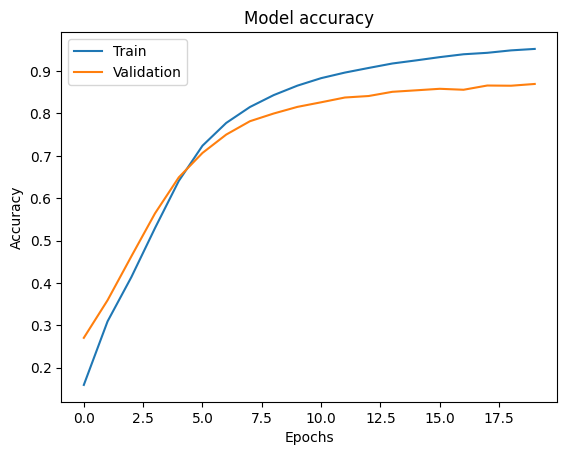

In [36]:
# plot results
plt.plot(history_baseline.history['accuracy'])
plt.plot(history_baseline.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
# Evaluate the models
print("Baseline model")
print("Train accuracy: {}".format(baseline.evaluate(X_train, Y_train)[1]))
print("Validation accuracy: {}".format(baseline.evaluate(X_val, Y_val)[1]))

Baseline model


62/62 [==============================] - 2s 27ms/step - loss: 0.1809 - accuracy: 0.9562
Train accuracy: 0.9562112092971802
40/40 [==============================] - 1s 27ms/step - loss: 0.4904 - accuracy: 0.8696
Validation accuracy: 0.8696405291557312


### Model 1

In [38]:
history_model1 = model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=20, verbose=1)

Epoch 1/20
16/16 [==============================] - 21s 745ms/step - loss: 3.2361 - accuracy: 0.1528 - val_loss: 2.9370 - val_accuracy: 0.2168
Epoch 2/20
16/16 [==============================] - 11s 683ms/step - loss: 2.7969 - accuracy: 0.2211 - val_loss: 2.6913 - val_accuracy: 0.2399
Epoch 3/20
16/16 [==============================] - 11s 709ms/step - loss: 2.5325 - accuracy: 0.2864 - val_loss: 2.4037 - val_accuracy: 0.3536
Epoch 4/20
16/16 [==============================] - 11s 709ms/step - loss: 2.1760 - accuracy: 0.4154 - val_loss: 2.0172 - val_accuracy: 0.4695
Epoch 5/20
16/16 [==============================] - 12s 728ms/step - loss: 1.7652 - accuracy: 0.5385 - val_loss: 1.6461 - val_accuracy: 0.5693
Epoch 6/20
16/16 [==============================] - 12s 752ms/step - loss: 1.4007 - accuracy: 0.6389 - val_loss: 1.3651 - val_accuracy: 0.6389
Epoch 7/20
16/16 [==============================] - 12s 779ms/step - loss: 1.1255 - accuracy: 0.7221 - val_loss: 1.1438 - val_accuracy: 0.7085

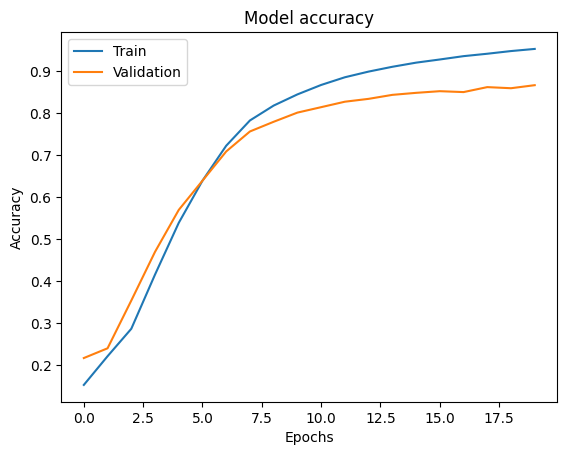

In [39]:
# plot results
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
# Evaluate the models
print("Model 1")
print("Train accuracy: {}".format(model1.evaluate(X_train, Y_train)[1]))
print("Validation accuracy: {}".format(model1.evaluate(X_val, Y_val)[1]))

Model 1


62/62 [==============================] - 3s 49ms/step - loss: 0.1896 - accuracy: 0.9571
Train accuracy: 0.9570801854133606
40/40 [==============================] - 2s 44ms/step - loss: 0.5018 - accuracy: 0.8662
Validation accuracy: 0.8662091493606567
20/20 [==============================] - 1s 44ms/step - loss: 0.4311 - accuracy: 0.8782
Test accuracy: 0.8782244920730591
20/20 [==============================] - 2s 43ms/step
(638, 100, 47)
(638, 100)
(638, 100)
(63800,)
(63800,)
0
14064
14064
Macro F1 score: 0.7096058528931841


### Model 2

In [41]:
history_model2 = model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=20, verbose=1)

Epoch 1/20
16/16 [==============================] - 12s 485ms/step - loss: 3.8214 - accuracy: 0.0760 - val_loss: 3.7854 - val_accuracy: 0.0451
Epoch 2/20
16/16 [==============================] - 7s 423ms/step - loss: 3.7593 - accuracy: 0.0881 - val_loss: 3.7281 - val_accuracy: 0.0948
Epoch 3/20
16/16 [==============================] - 7s 429ms/step - loss: 3.7054 - accuracy: 0.0898 - val_loss: 3.6791 - val_accuracy: 0.0866
Epoch 4/20
16/16 [==============================] - 7s 416ms/step - loss: 3.6558 - accuracy: 0.1002 - val_loss: 3.6328 - val_accuracy: 0.1140
Epoch 5/20
16/16 [==============================] - 7s 442ms/step - loss: 3.6093 - accuracy: 0.1343 - val_loss: 3.5888 - val_accuracy: 0.1849
Epoch 6/20
16/16 [==============================] - 7s 437ms/step - loss: 3.5638 - accuracy: 0.1991 - val_loss: 3.5411 - val_accuracy: 0.2248
Epoch 7/20
16/16 [==============================] - 7s 430ms/step - loss: 3.5140 - accuracy: 0.2336 - val_loss: 3.4917 - val_accuracy: 0.2132
Epoch

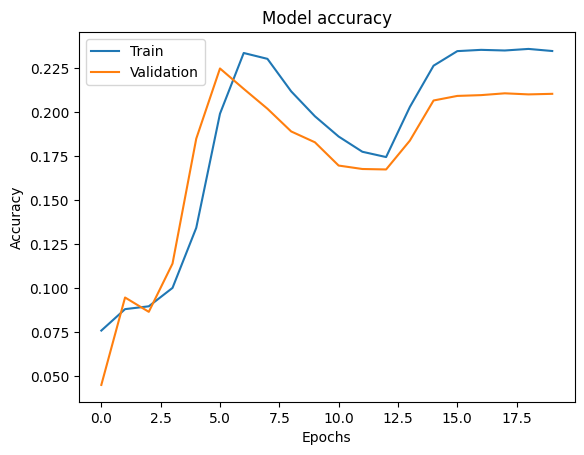

In [42]:
# plot results
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [43]:
# Evaluate the models
print("Model 2")
print("Train accuracy: {}".format(model2.evaluate(X_train, Y_train)[1]))
print("Validation accuracy: {}".format(model2.evaluate(X_val, Y_val)[1]))

Model 2


62/62 [==============================] - 2s 25ms/step - loss: 3.0359 - accuracy: 0.2348
Train accuracy: 0.23477670550346375
40/40 [==============================] - 1s 24ms/step - loss: 3.0524 - accuracy: 0.2104
Validation accuracy: 0.21040309965610504


# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible) 
* Comment the about errors and propose possible solutions on how to address them.

In [44]:
print("Train accuracy: {}".format(model1.evaluate(X_train, Y_train)[1]))
print("Validation accuracy: {}".format(model1.evaluate(X_val, Y_val)[1]))
print("Test accuracy: {}".format(model1.evaluate(X_test, Y_test)[1]))
print("Macro F1 score: {}".format(macro_f1(Y_test, model1.predict(X_test))))

62/62 [==============================] - 3s 40ms/step - loss: 0.1896 - accuracy: 0.9571
Train accuracy: 0.9570801854133606
40/40 [==============================] - 2s 41ms/step - loss: 0.5018 - accuracy: 0.8662
Validation accuracy: 0.8662091493606567
20/20 [==============================] - 1s 41ms/step - loss: 0.4311 - accuracy: 0.8782
Test accuracy: 0.8782244920730591
20/20 [==============================] - 1s 40ms/step
(638, 100, 47)
(638, 100)
(638, 100)
(63800,)
(63800,)
0
14064
14064
Macro F1 score: 0.7096058528931841
